# 0.1 Imports

In [361]:

import math
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import xgboost as xgb



from scipy                       import stats as ss
from boruta                      import BorutaPy
from tabulate                    import tabulate
from datetime                    import datetime
from datetime                    import datetime, timedelta
from matplotlib                  import gridspec
from sklearn.metrics             import mean_absolute_error, mean_squared_error
from IPython.display             import Image
from sklearn.ensemble            import RandomForestRegressor
from IPython.core.display        import HTML
from sklearn.linear_model        import LinearRegression, Lasso
from matplotlib.gridspec         import GridSpec
from sklearn.preprocessing       import RobustScaler, MinMaxScaler
from sklearn.preprocessing       import LabelEncoder
from sklearn.ensemble            import RandomForestRegressor


import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

# 0.2 Helper Functions

In [569]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    mae_list= []
    mape_list = []
    rmse_list = []

    for k in reversed ( range (1, kfold+1 ) ):
        if verbose:
            print( '\nKFOLD Number: {}'.format( k ) )

        # statarting and date for validation
        validation_start_date = x_training ['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        #Filtering dataset
        training = x_training[x_training[ 'date'] < validation_start_date]
        validation = x_training[(x_training[ 'date'] >= validation_start_date) & (x_training[ 'date'] <= validation_end_date)]

        # Training and validation dataset
        #Training
        xtraining = training.drop([ 'date','sales' ], axis=1 )
        ytraining = training['sales']

        xvalidation = validation.drop([ 'date','sales' ], axis=1 )
        yvalidation = validation['sales']

        #model
        m = model.fit (xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation )

        #Performace
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        #Store performace of each kfold interation
        mae_list.append( m_result[ 'MAE'] )
        mape_list.append( m_result[ 'MAPE'] )
        rmse_list.append( m_result[ 'RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list), 2).astype( str ),
                              'MAPE CV': np.round( np.mean( mape_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list), 2).astype( str ),
                              'RSME CV': np.round( np.mean( rmse_list), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list), 2).astype( str ) }, index=[0])

# =========================================================================================


def mean_absolute_percentage_error ( y, yhat):
    return np.mean(np.abs((y - yhat) / y) )


# ========================================================


def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error ( y, yhat )
    mape = mean_absolute_percentage_error ( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame ( { 'Model Name': model_name,
                            'MAE' : mae,
                            'MAPE' : mape,
                            'RMSE' : rmse }, index=[0] )

# ========================================================

def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1) 
    rcorr = r - (r-1)**2/(n-1) 

    return  np.sqrt( (chi2corr/n) / (min ( kcorr-1, rcorr-1) ) )


# =============================================================

def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()
    

In [363]:
%matplotlib inline 
%matplotlib notebook

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option ('display.expand_frame_repr', False)

sns.set()

In [364]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0 Loading Data

In [365]:

df_sales_raw = pd.read_csv ('/Users/adriele/Documents/repos/ds_em_producao/dataset/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('/Users/adriele/Documents/repos/ds_em_producao/dataset/store.csv', low_memory = False)

# Merge
df_raw = pd.merge (df_sales_raw,df_store_raw)


## 1.1 Rename columns

In [366]:
df1 = df_raw.copy()
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [367]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map (snakecase , cols_old))

# rename
df1.columns = cols_new

##  1.2 Data Dimersions

In [368]:
print ('number of cols {}'.format (df1.shape [0] ) )
print ('number of rows {}'.format (df1.shape [1] ) )

number of cols 1017209
number of rows 18


## 1.3 Data Types

In [369]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [370]:
df1['date']= pd.to_datetime (df1 ['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [371]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5  Fillout NA

In [372]:
df1 ['competition_distance'].max ()

75860.0

In [373]:
# Competition_distance
df1 ['competition_distance'] = df1 ['competition_distance'].apply ( lambda x: 200000.0 if math.isnan (x) else x )

# Competition_open_since_month
df1 ['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan (x ['competition_open_since_month']) else x ['competition_open_since_month'], axis = 1)

# Competition_open_since_year
df1 ['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['competition_open_since_year']) else x ['competition_open_since_year'], axis = 1)

# Promo2_since_week
df1 ['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan (x ['promo2_since_week']) else x ['promo2_since_week'], axis = 1)

# Promo2_since_year
df1 ['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan (x ['promo2_since_year']) else x ['promo2_since_year'], axis = 1)

# Promo Interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1 ['promo_interval'].fillna (0, inplace = True)

df1 ['month_map'] = df1 ['date'].dt.month.map(month_map)

df1 ['is_promo'] = df1 [['promo_interval', 'month_map']].apply (lambda x: 0 if x ['promo_interval'] == 0 
                                                                else 1 if x['month_map'] in x['promo_interval'].split (',') else 0, axis =1)

In [374]:
df1.isna().sum ()
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Changing Type

In [375]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [376]:
df1['competition_open_since_month'] = df1 ['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1 ['competition_open_since_year'].astype (int)


df1['promo2_since_week'] = df1 ['promo2_since_week'].astype (int)
df1['promo2_since_year'] = df1 ['promo2_since_year'].astype (int)



In [377]:
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Startistical

In [378]:
num_attributes = df1.select_dtypes (include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes ( exclude = ['int64', 'float64', 'datetime64[ns]'])


## 1.7.1

In [379]:
# Central Tendency - mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean) ).T
ct2 = pd.DataFrame (num_attributes.apply (np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply (np.std) ).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max () -x.min ()) ).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis ()) ).T

# Concatane
m =pd.concat ([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo2_since_year', ylabel='Density'>

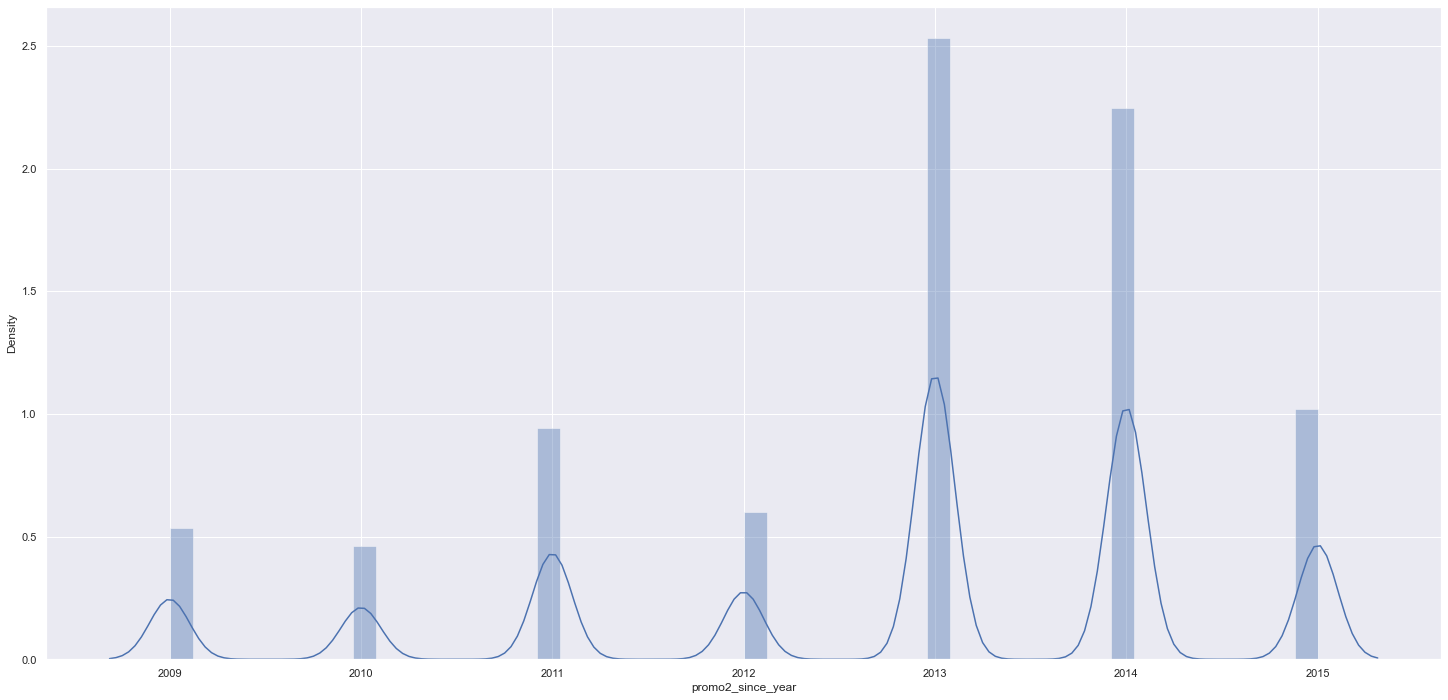

In [380]:
sns.distplot (df1['promo2_since_year'])

/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

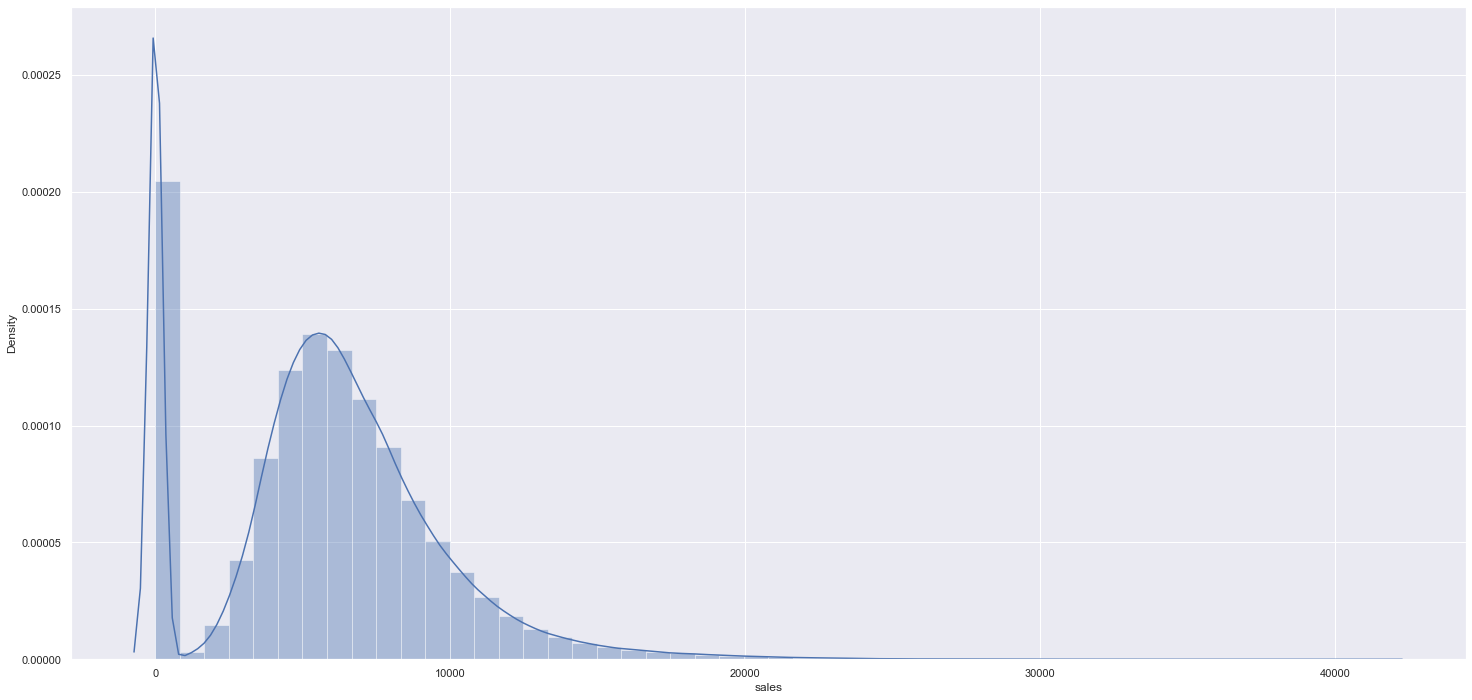

In [381]:
sns.distplot (df1['sales'])

## 1.7.2 Attributes Category

In [382]:
cat_attributes.apply (lambda x: x.unique().shape [0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

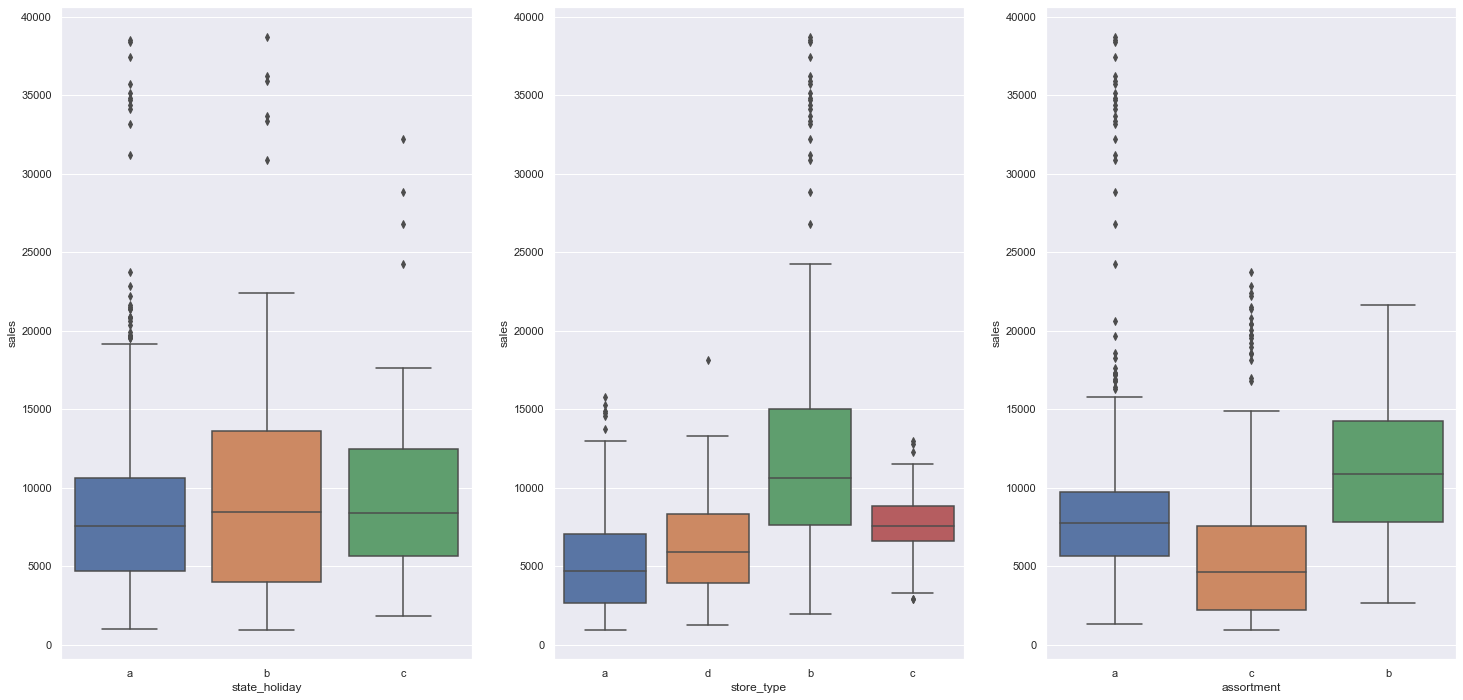

In [383]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot (x = 'state_holiday', y='sales', data = aux1)

plt.subplot (1, 3, 2)
sns.boxplot (x = 'store_type', y='sales', data = aux1)

plt.subplot (1, 3, 3)
sns.boxplot (x = 'assortment', y='sales', data = aux1)

# 2.0 Feature Engeneering -MindMap


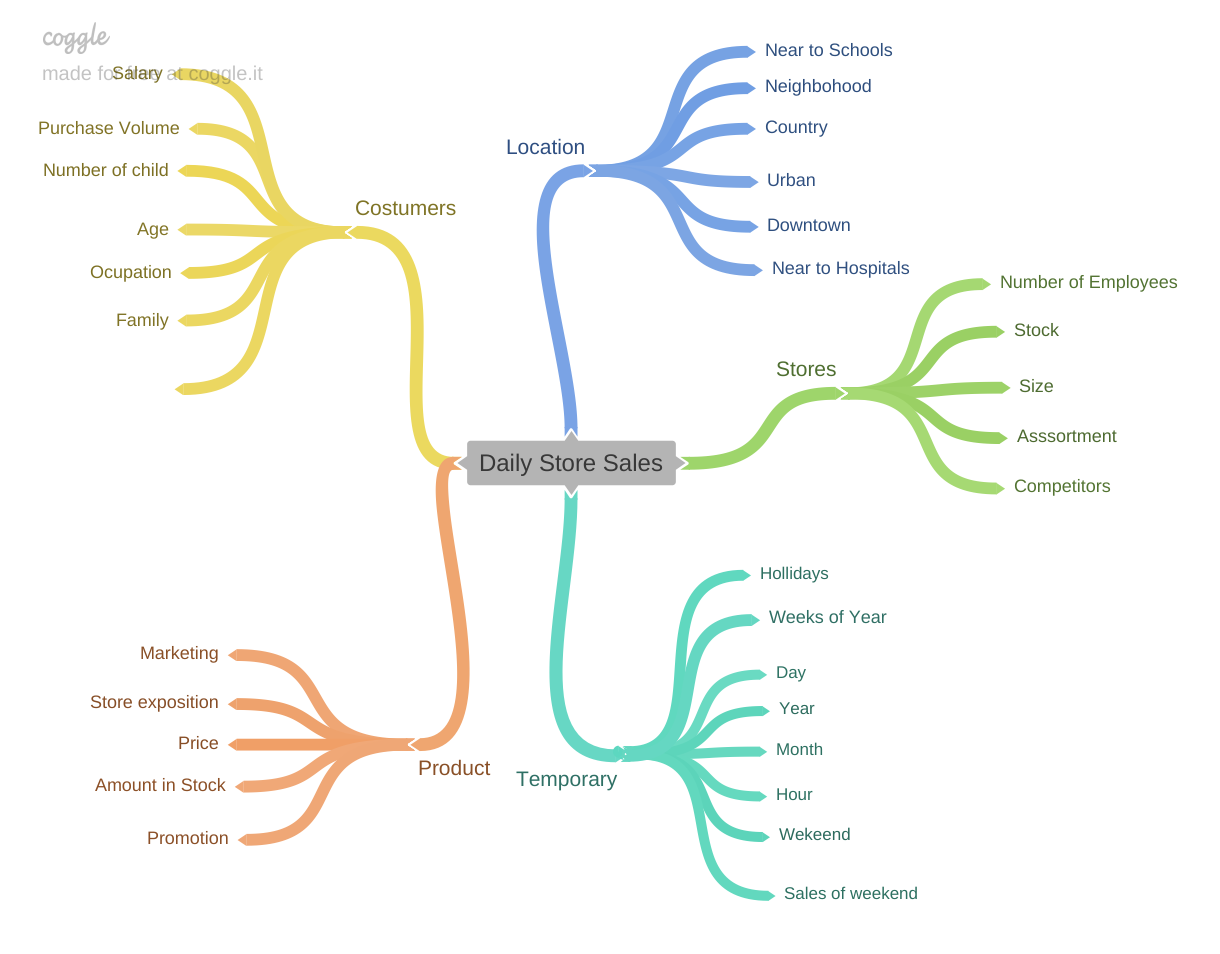

In [384]:
Image ('/Users/adriele/Documents/repos/ds_em_producao/image/mindmap.png')

## 2.1.1 Store Hipothesys


 1. - Stores with largest employment number should sall over/more.
 2. - Stores with largest stock capacity  should sell over.
 3. - Stores with greater size should sell over/more.
 4. - Stores with biggest assortment should sell over/more.
 5. - Stores with competitors around should sell less.
 6. - Stores with longer competitors should sell over/more.
 
 

## 2.1.2 Product Hipothesys

 1. - Stores that invest in Marketing should sall over/more.
 2. - Stores with largest product exposition should sell over.
 3. - Stores with price product less should sell over/more.
 4. - Stores with agressive promotion (descout) should sell over/more.
 5. - Stores with activate promotion for more time should sell over/more.
 6. - Stores with more promotion days should sell over/more.
 7. - Stores with consecultive promotion should sell over/more.
 

## 2.1.3 Time Hipothesys

 1. - Opened stores on Christimas holliday should sall over/more.
 2. - Stores should sell more throughout the year.
 3. - Stores should sell more on the second semestre of the year.
 4. - Stores  should sell more after 10th day of eatch month.
 5. - Stores should sell less on wekeends.
 6. - Stores should sell less on hollidays school.
 

##  2.2 Final Hipothesys List

 1. - Stores with biggest assortment should sell over/more.
 2. - Stores with competitors around should sell less.
 3. - Stores with longer competitors should sell over/more.
 4. - Stores with activate promotion for more time should sell over/more.
 5. - Stores with more promotion days should sell over/more.
 6. - Stores with consecultive promotion should sell over/more.
 7. - Opened stores on Christimas holliday should sall over/more.
 8. - Stores should sell more throughout the year.
 9. - Stores should sell more on the second semestre of the year.
 10. - Stores  should sell more after 10th day of eatch month.
 11. - Stores should sell less on wekeends.
 12. - Stores should sell less on hollidays school.

## 2.3 Feature Engeneering


In [385]:
df2 = df1.copy ()


In [386]:
# year
df2 ['year'] = df2 ['date'].dt.year

# Month
df2 ['month'] = df2 ['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# week of year
df2 ['week_of_year'] = df2 ['date'].dt.weekofyear

# Year Week
df2['year_week'] = df2 ['date'].dt.strftime( '%Y-%W')


# #Competition since
df2 ['competition_since'] = df2.apply( lambda x: datetime.datetime (year = x ['competition_open_since_year'], month = x ['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month '] = (( df2 ['date'] - df2 ['competition_since']) /30).apply (lambda x: x.days ).astype (int)


# # Promo Since
df2 ['promo_since'] = df2 ['promo2_since_year'].astype (str) + '-' + df2 ['promo2_since_week'].astype (str)
df2 ['promo_since'] = df2 ['promo_since'].apply ( lambda x:  datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = (( df2 ['date'] -df2 ['promo_since']) /7).apply (lambda x: x.days).astype (int)

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')

# state Holidays
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else  'regular_day')


/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_14631/2628233289.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2 ['week_of_year'] = df2 ['date'].dt.weekofyear


In [387]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0  FILTERING VARIABLES

In [388]:
df3 = df2.copy ()

## 3.1  Filtering Rows

In [389]:
df3 = df3[(df3['open'] != 0) & (df3 ['sales'] > 0)]


## 3.2 Selecting Columns

In [390]:
# Droping columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis =1)

# 4.0  EDA - Exploratory Data Analisys

In [391]:
df4 = df3.copy ()

## 4.1 Analise Univariada

## 4.1.1 Response variable

/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

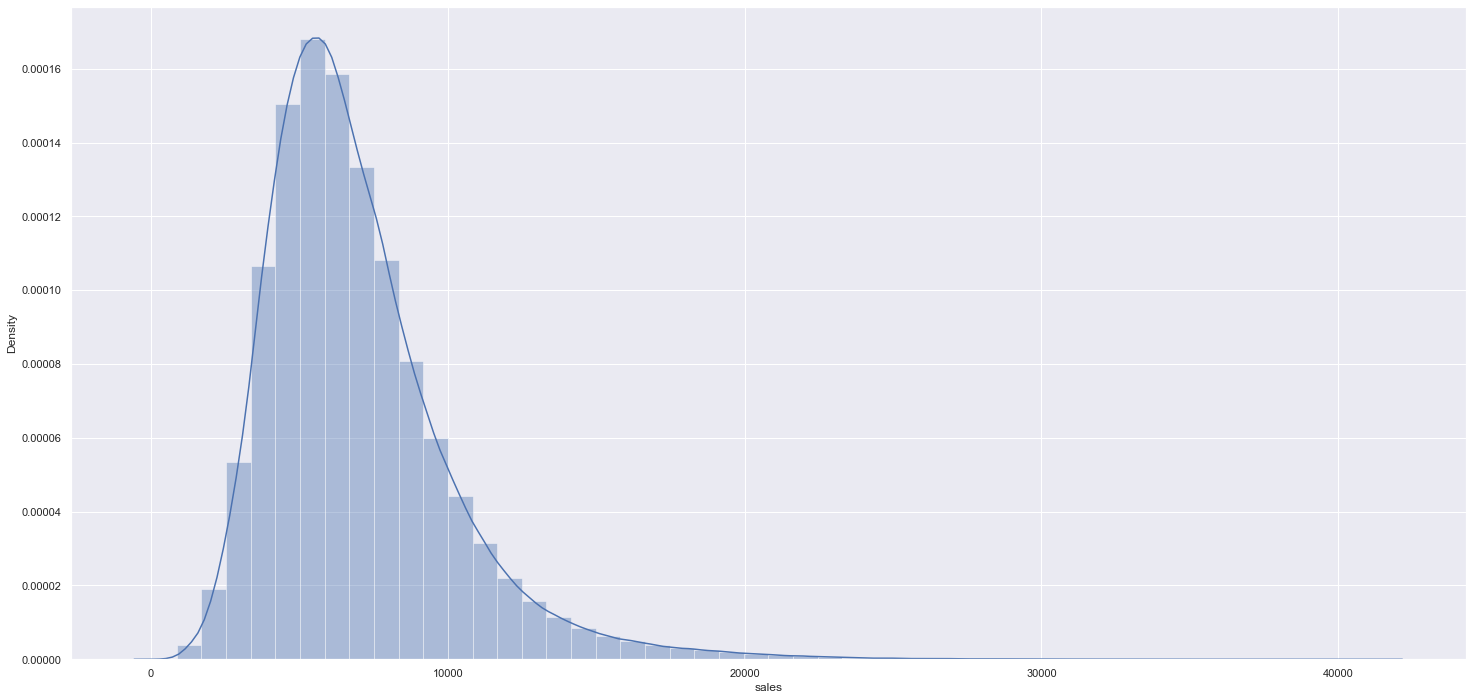

In [392]:
sns.distplot (df4['sales'])

## 4.1.2 Numerical Variable

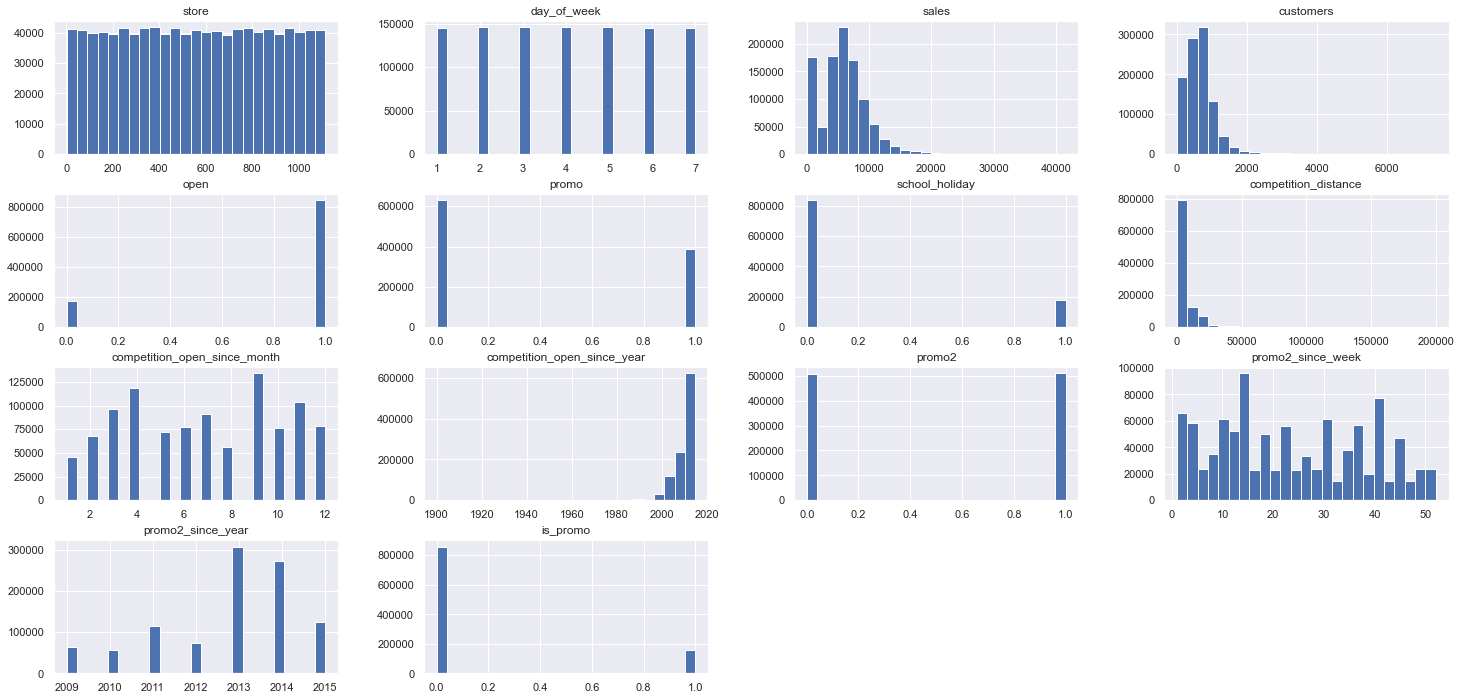

In [393]:
num_attributes.hist(bins =25);


## 4.1.3 Categorical Variable

In [394]:
df4 ['state_holiday'].drop_duplicates()

0           regular_day
1243     public_holiday
76852    easter_holiday
76953         christmas
Name: state_holiday, dtype: object

/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

<AxesSubplot:xlabel='sales', ylabel='Density'>

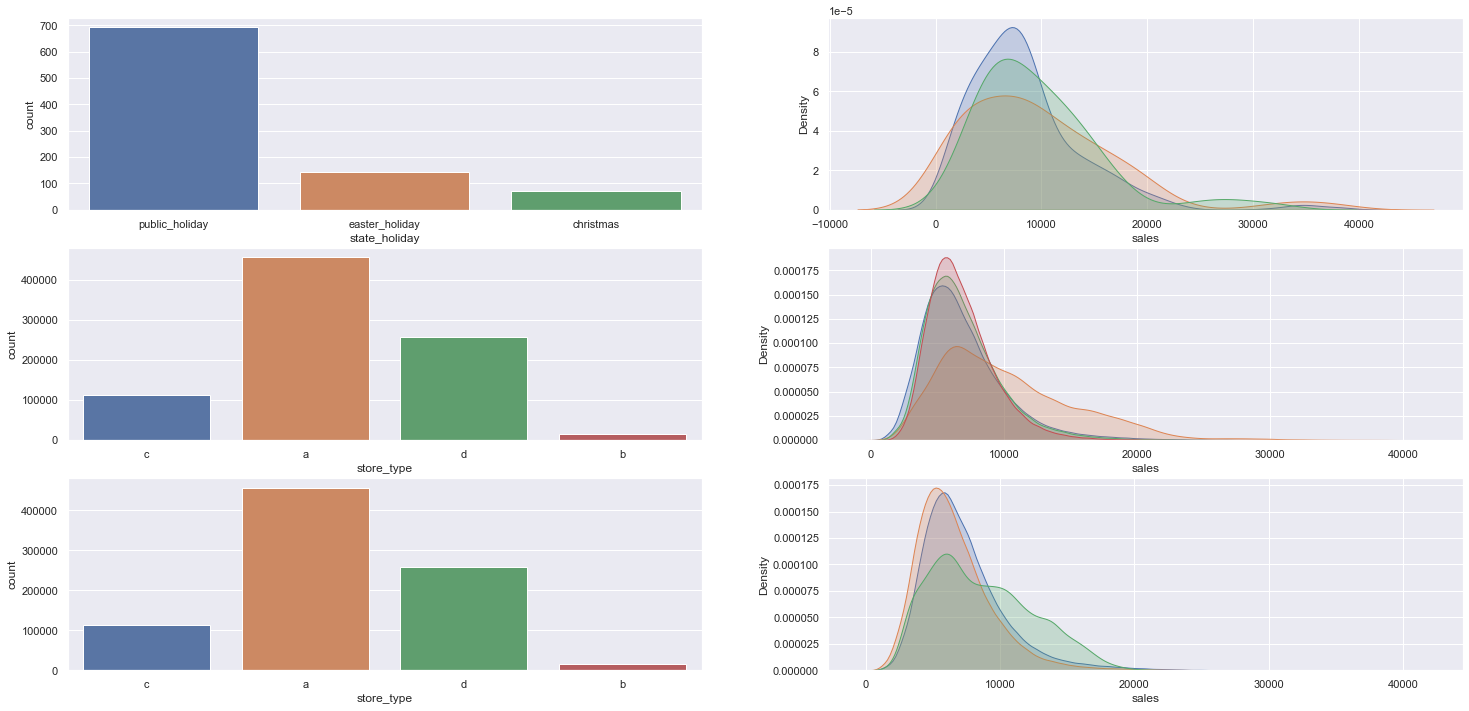

In [395]:
# state Holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='christmas',
            shade=True)

# store Type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra',
            shade=True)

## 4.2 Analise Bivariada - Hypothesys validation

## H1. - Stores with biggest assortment should sell more.

**FALSE** Stores with biggest assortment sell LESS.
 

<AxesSubplot:xlabel='year_week'>

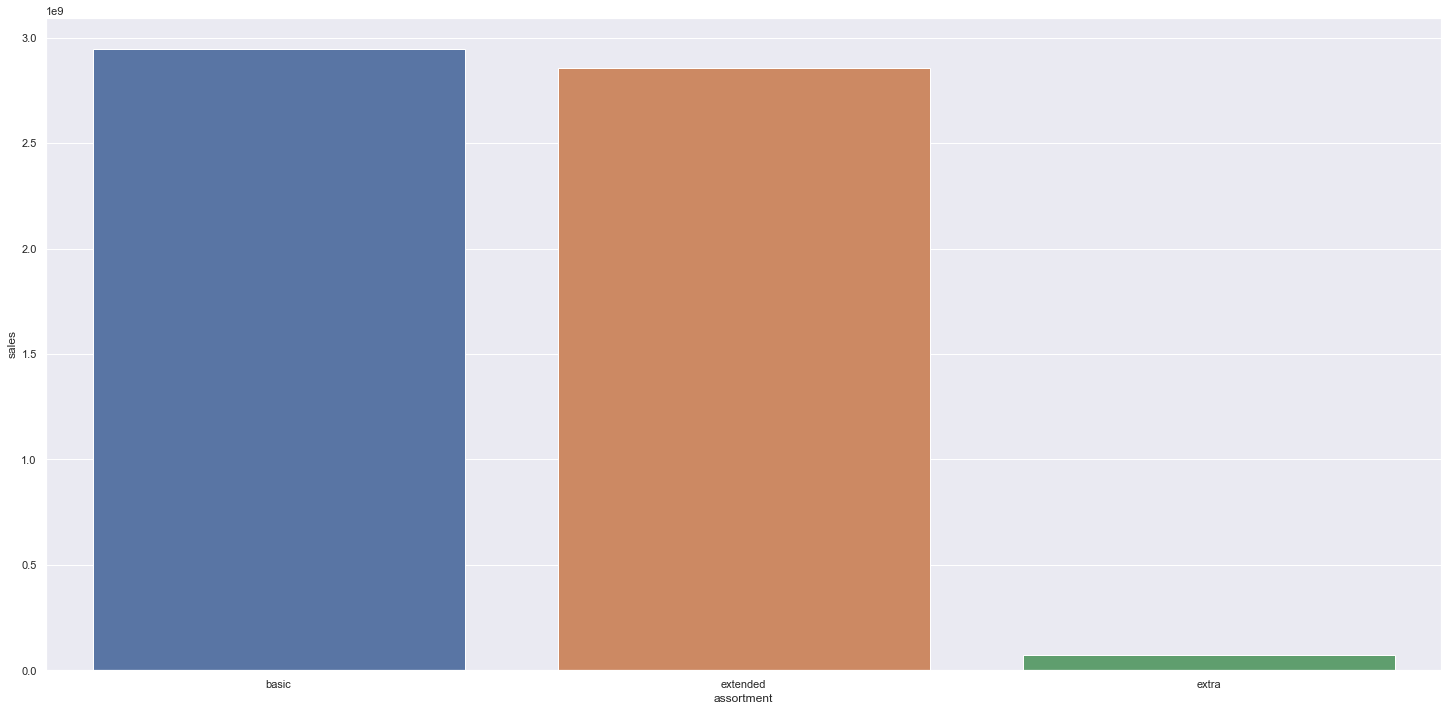

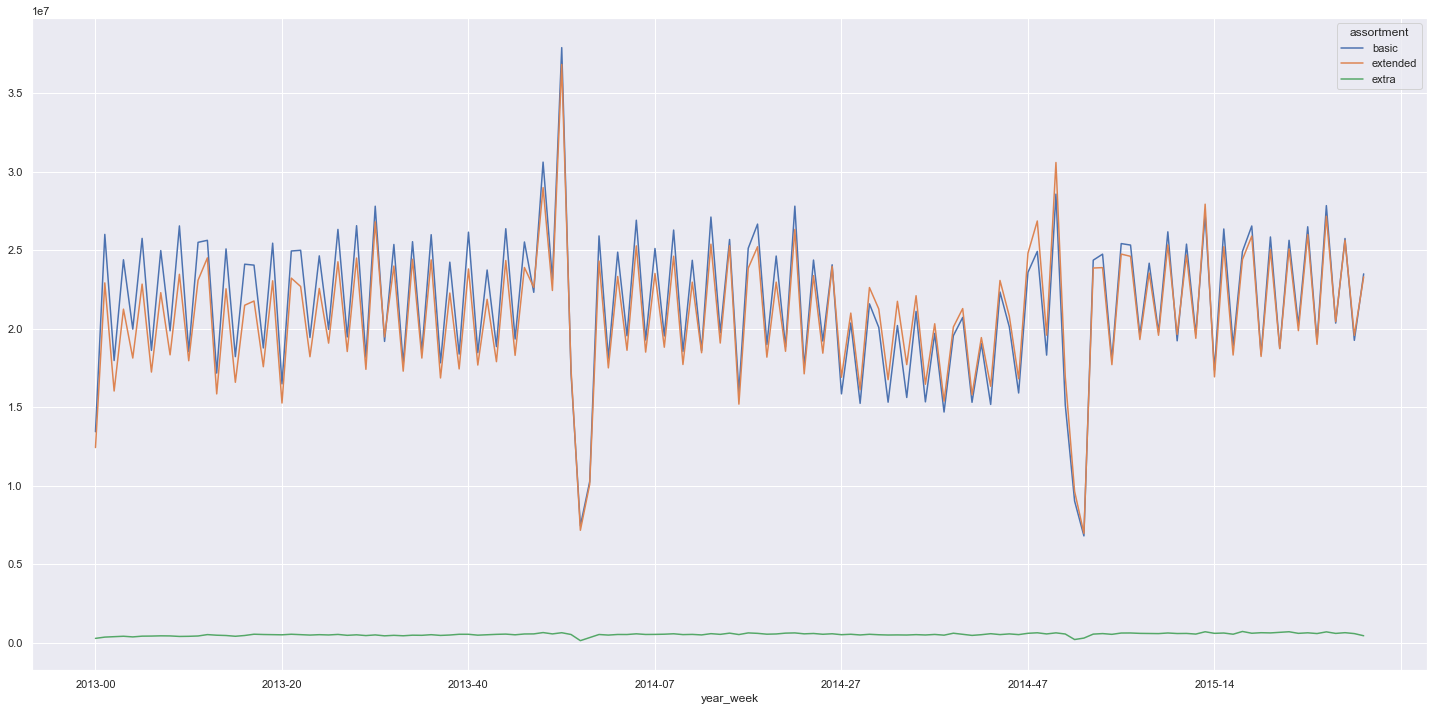

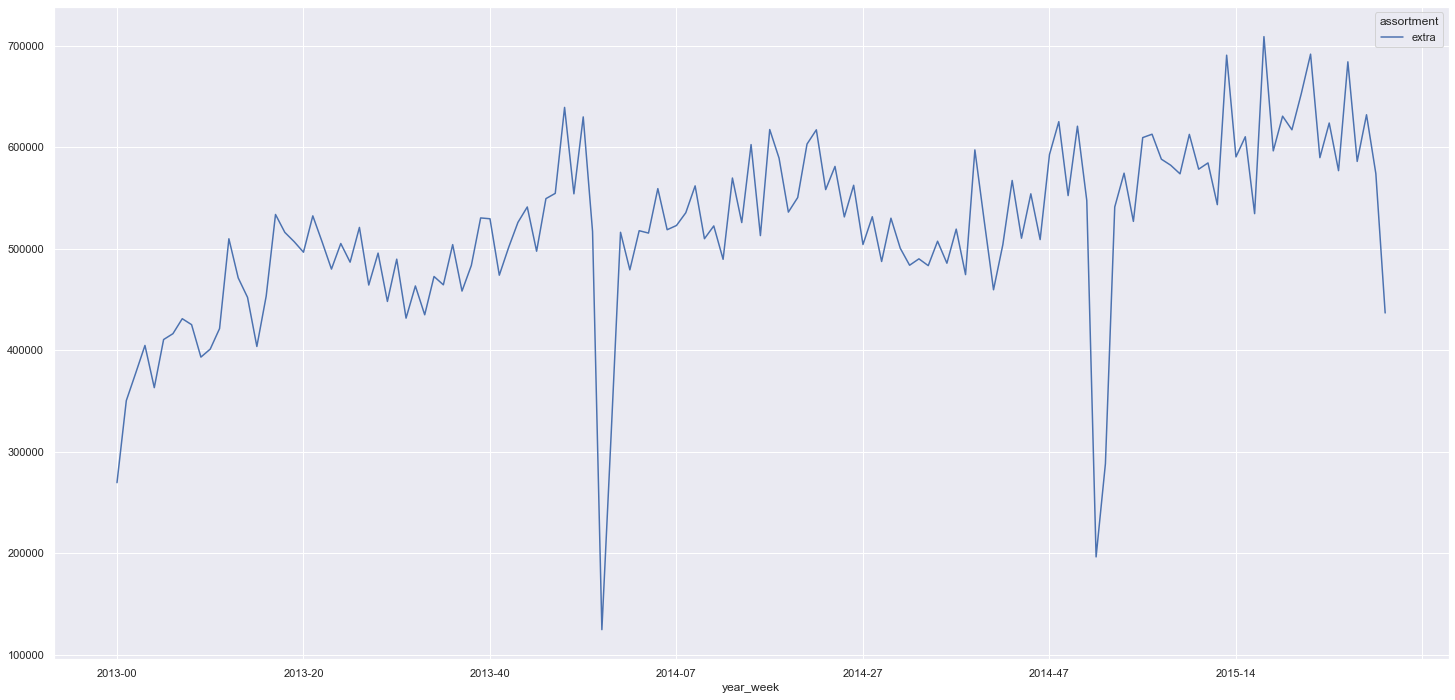

In [396]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot (index= 'year_week', columns = 'assortment', values ='sales').plot ()

aux3 = aux2[aux2 ['assortment'] == 'extra'] 

aux3.pivot (index= 'year_week', columns = 'assortment', values ='sales').plot ()

## H2. - Stores with competitors around should sell less.
- **FALSE** Stores with competitiors nearby sells MORE.
 

<AxesSubplot:>

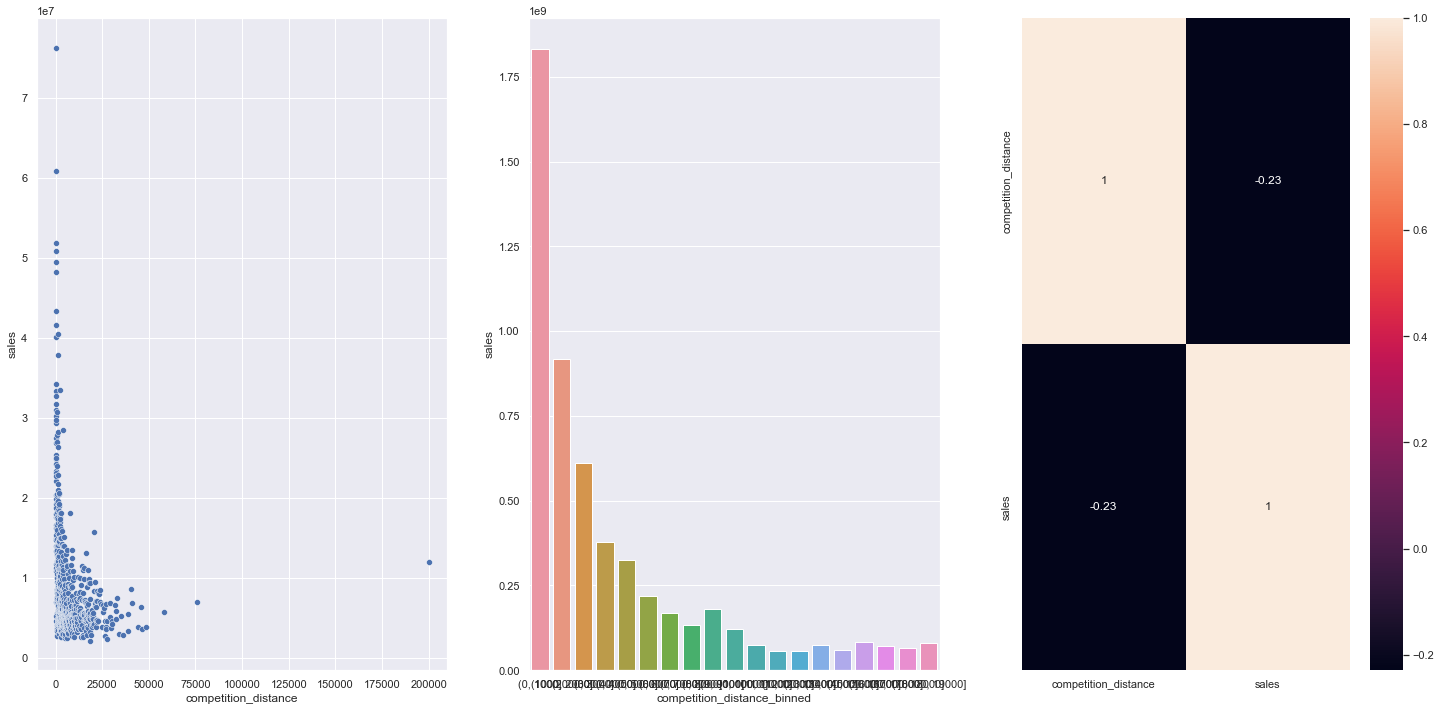

In [397]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# Granulatin
plt.subplot (1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# Bars
plt.subplot (1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

# Correlation metrics
plt.subplot (1,3,3)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)



<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

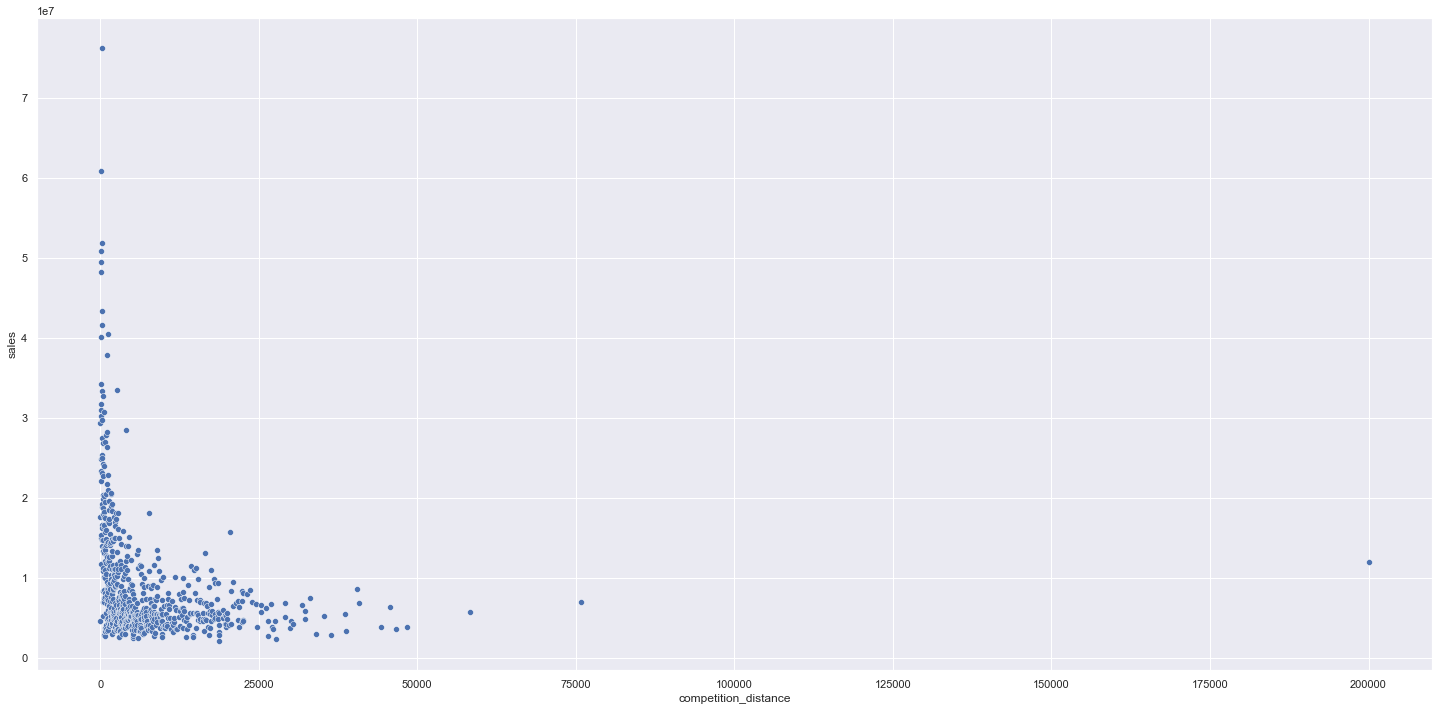

In [398]:
aux3 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index ()
sns.scatterplot(x='competition_distance', y='sales', data=aux3)

## H3. - Stores with longer/older competitors should sell more.
**FALSE** Stores with older competitors **sells LESS**!

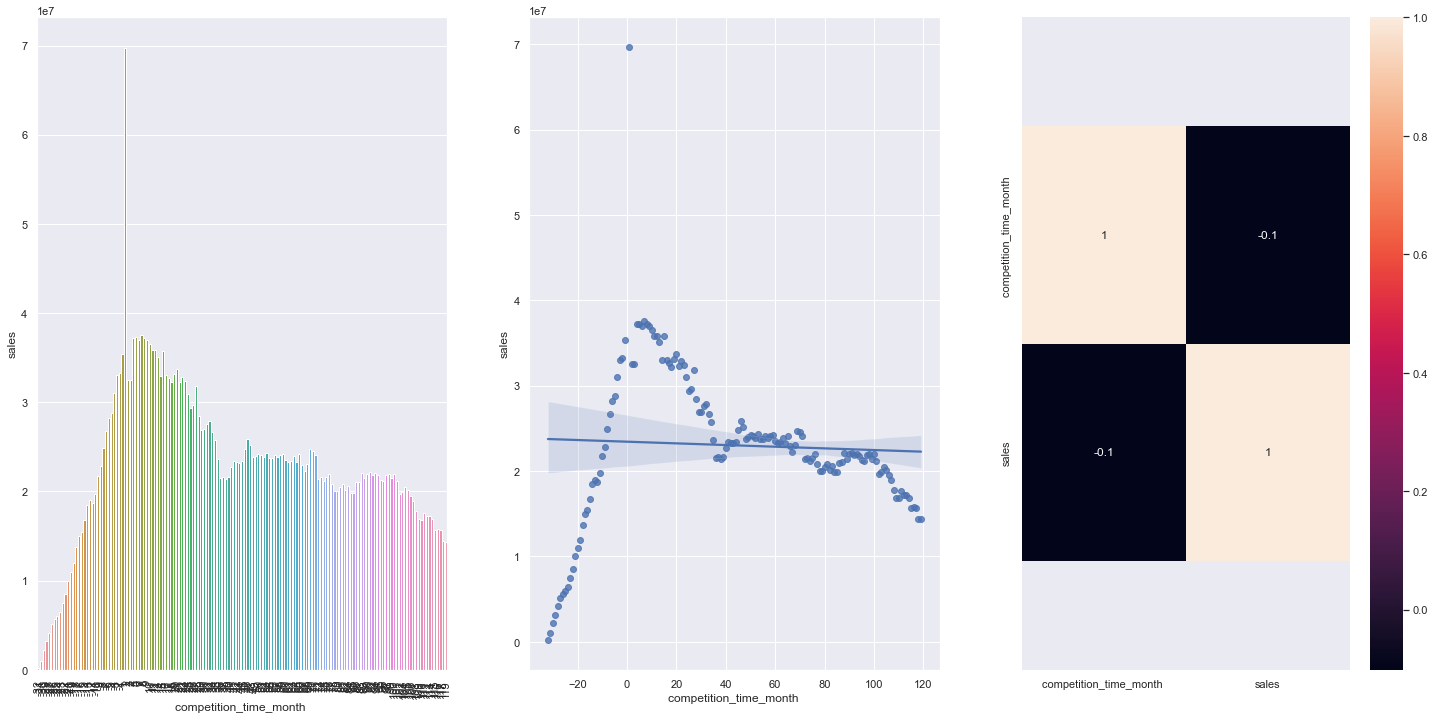

In [399]:

plt.subplot (1,3,1)

aux1 = df4 [['competition_time_month ', 'sales']].groupby( 'competition_time_month ').sum().reset_index()
aux2 = aux1 [( aux1 ['competition_time_month '] < 120) & (aux1['competition_time_month '] != 0)]
sns.barplot( x='competition_time_month ', y='sales', data=aux2);
plt.xticks (rotation = 90);

plt.subplot (1,3,2)
sns.regplot (x = 'competition_time_month ', y='sales', data = aux2);

plt.subplot (1,3,3)
x = sns.heatmap (aux1.corr (method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim (bottom + 0.5, top-0.5);


## H4. - Stores with activate promotion for more time should sell more.
**FALSE** Stores with long activate promotion **sell less**, after some time.

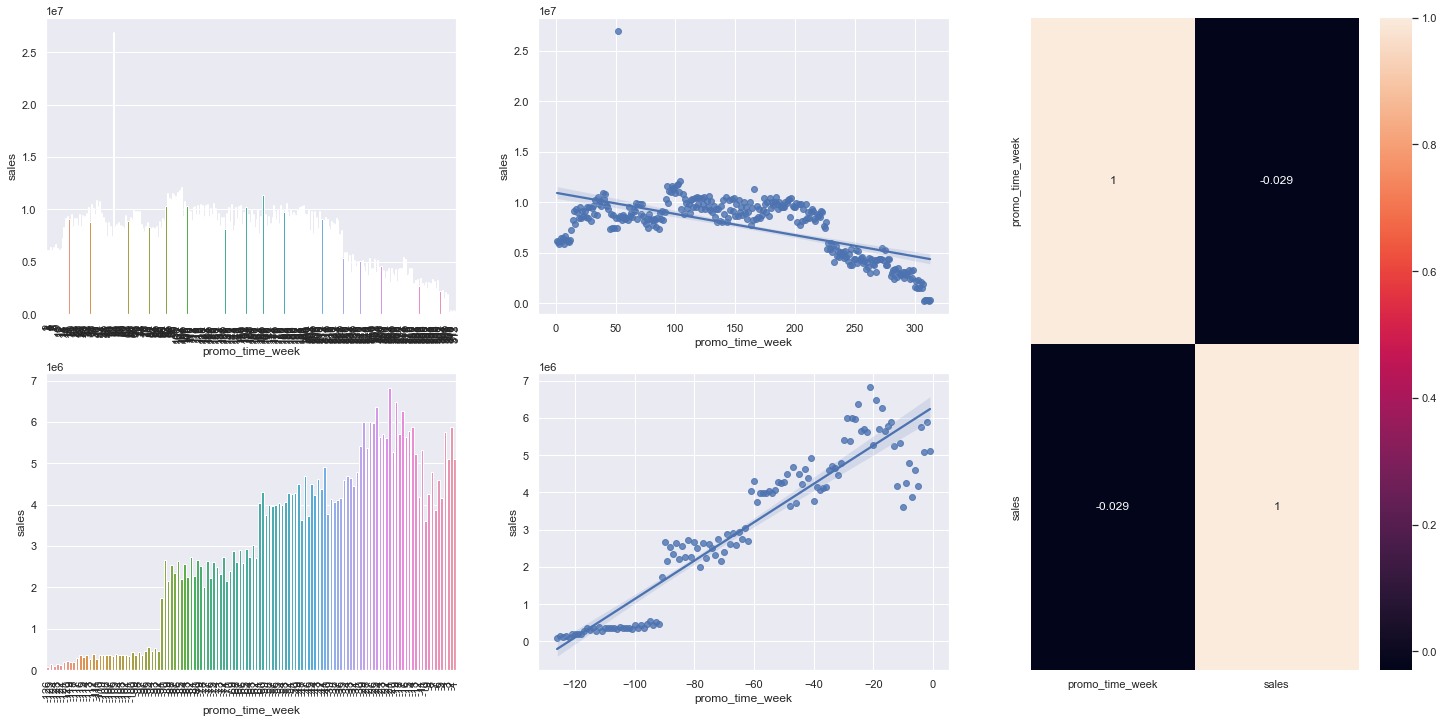

In [400]:

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec (2, 3)

plt.subplot(grid [0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid [0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid [1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid [1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);


plt.subplot ( grid [:, 2])
sns.heatmap (aux1.corr( method = 'pearson'), annot = True);



##  H5. - Stores with more promotion days should sell more.
 -Next CRISP cicle.

## H6. - Stores with consecultive (extended)  promotion should sell more.

**FALSE** Stores with extend promotion sell **less**.

In [401]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


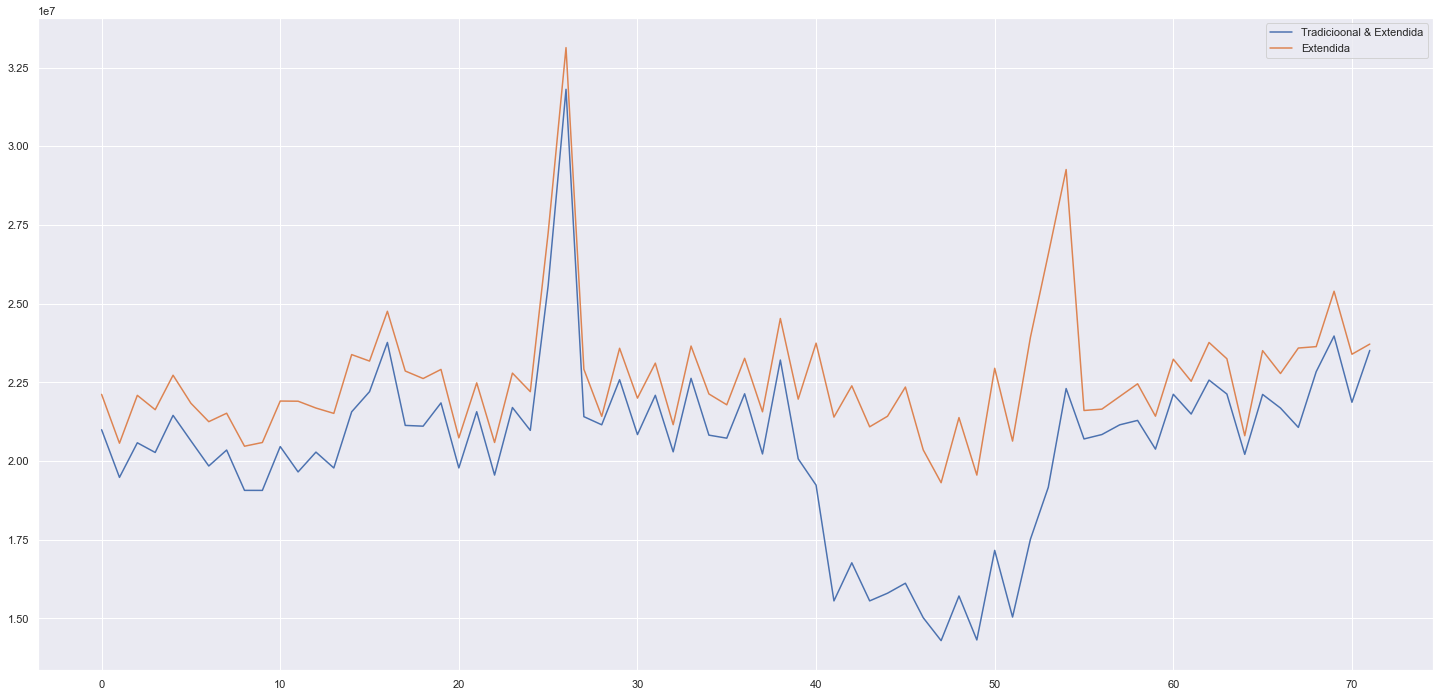

In [402]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby ('year_week').sum ().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby ('year_week').sum ().reset_index()
aux2.plot( ax=ax)

ax.legend(labels = ['Tradicioonal & Extendida', 'Extendida']);

## H7 - Opened stores on Christimas holliday should sall over/more.
**FALSE** Opened stores on Christ,mas sell **LESS**.
 

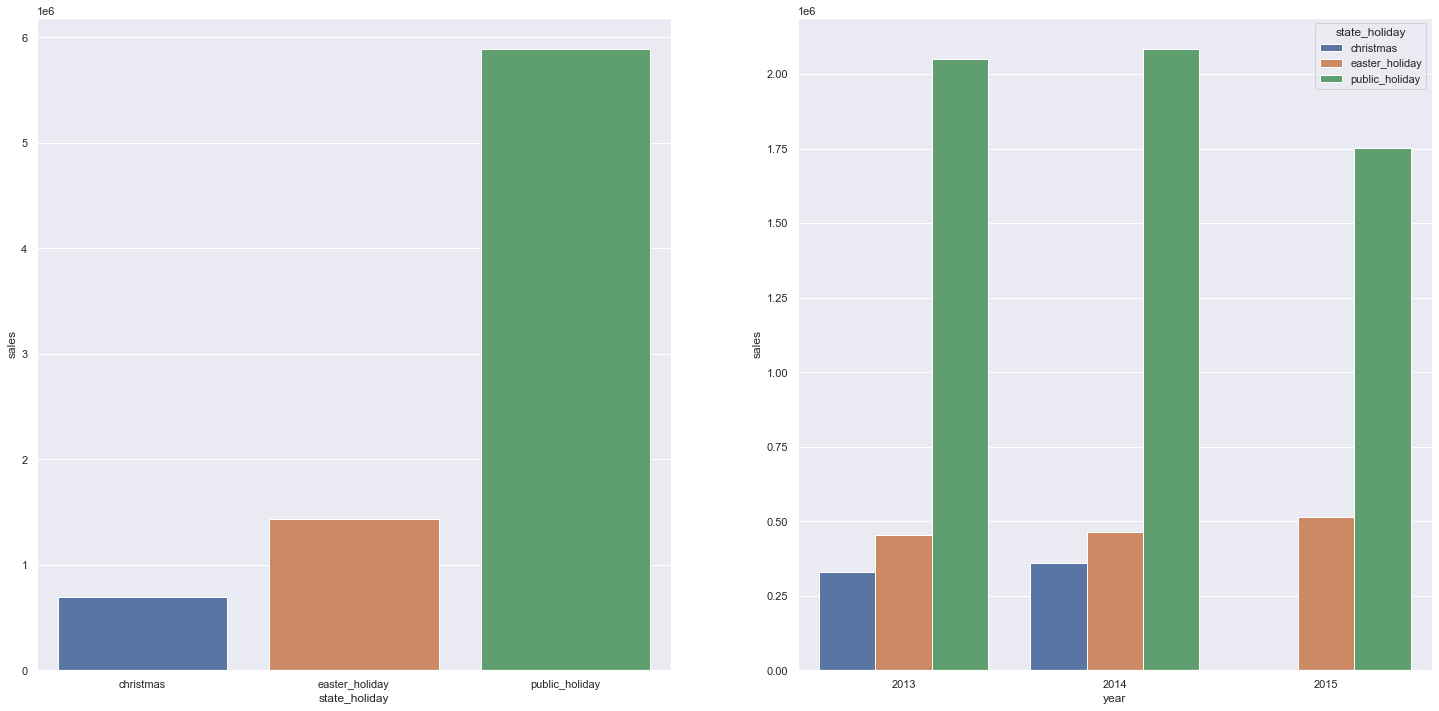

In [403]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby ('state_holiday').sum().reset_index()
sns.barplot (x = 'state_holiday', y= 'sales', data =aux1);

plt.subplot (1, 2, 2)
aux2 = aux [['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot (x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

## H8. - Stores should sell more throughout the year.
**FALSE** Stores sells **LESS** throughout the years.
 

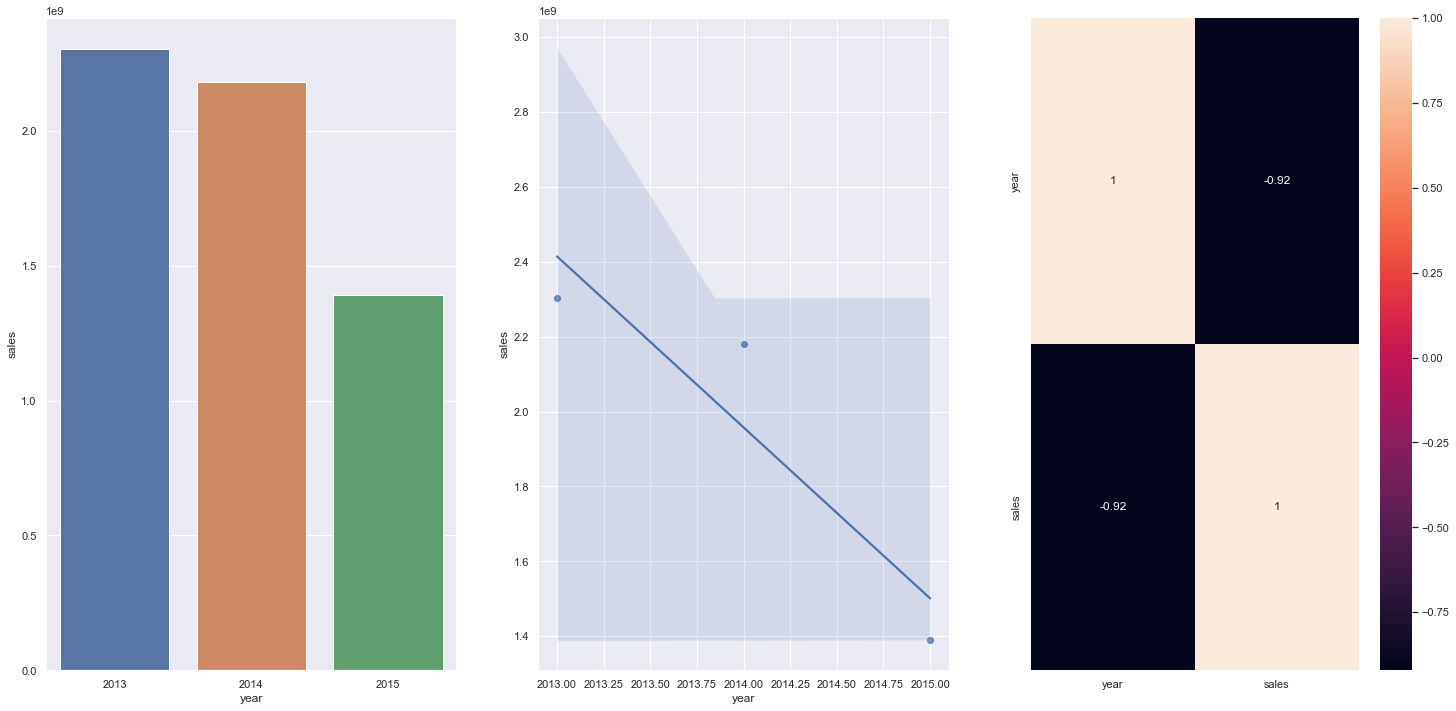

In [404]:
aux1 = df4 [['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot (x ='year', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x ='year', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

## H9. - Stores should sell more on the second semestre of the year.

**FALSE** Stores sell **LESS** on the second semestre of the year.
 

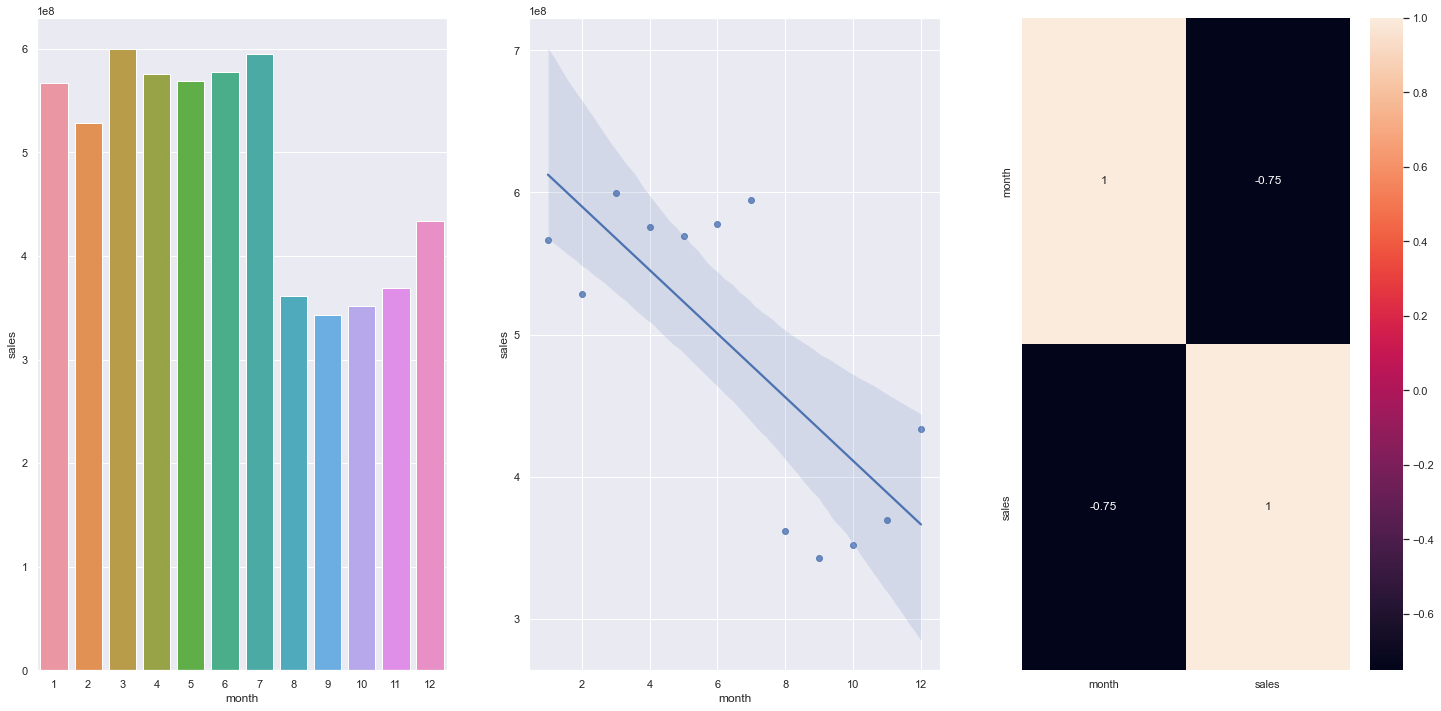

In [405]:
aux1 = df4 [['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot (x ='month', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x ='month', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

## H10. - Stores  should sell more after 10th day of eatch month.

**TRUE**
 

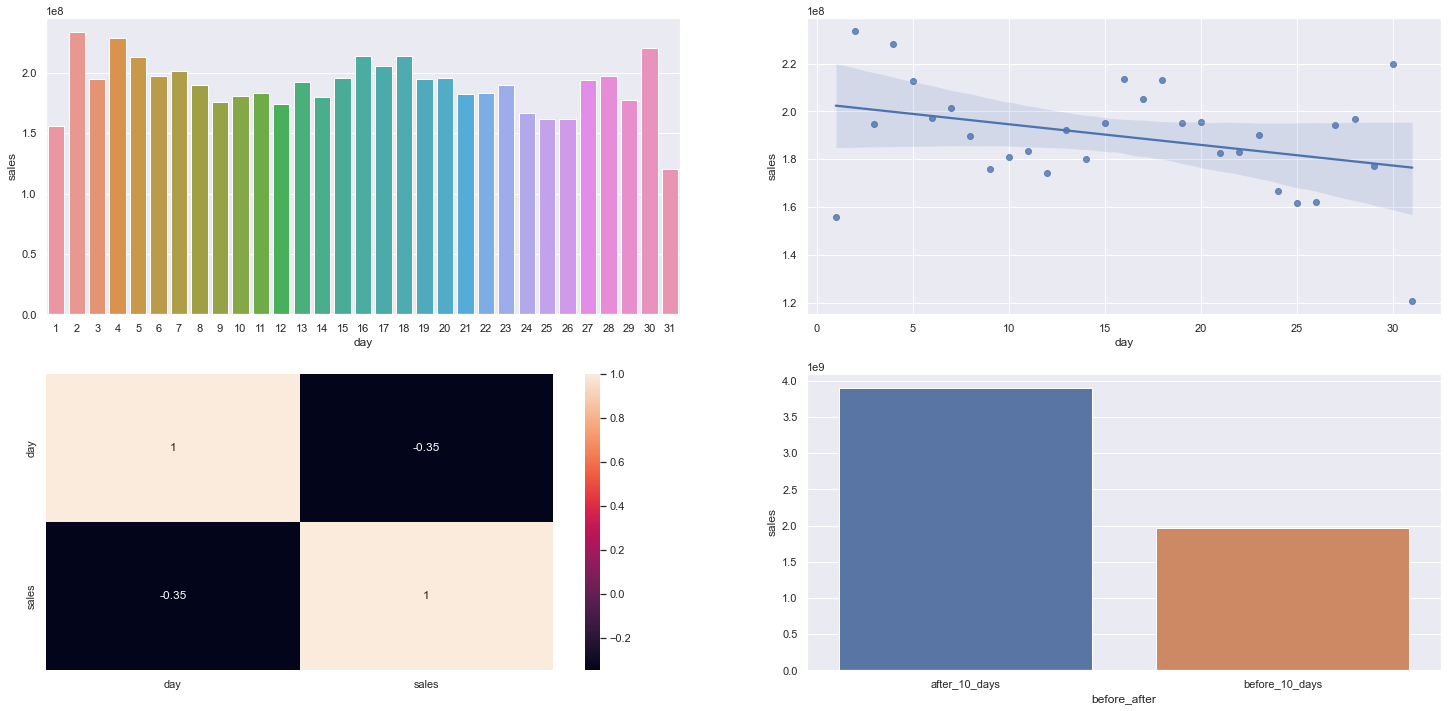

In [406]:
aux1 = df4 [['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot (x ='day', y = 'sales', data = aux1);

plt.subplot (2, 2, 2)
sns.regplot (x ='day', y = 'sales', data = aux1);

plt.subplot (2, 2, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1 [['before_after', 'sales']].groupby ('before_after').sum().reset_index()

plt.subplot (2, 2, 4)
sns.barplot ( x = 'before_after', y = 'sales', data = aux2);


## H11. - Stores should sell less on wekeends.
 **TRUE**

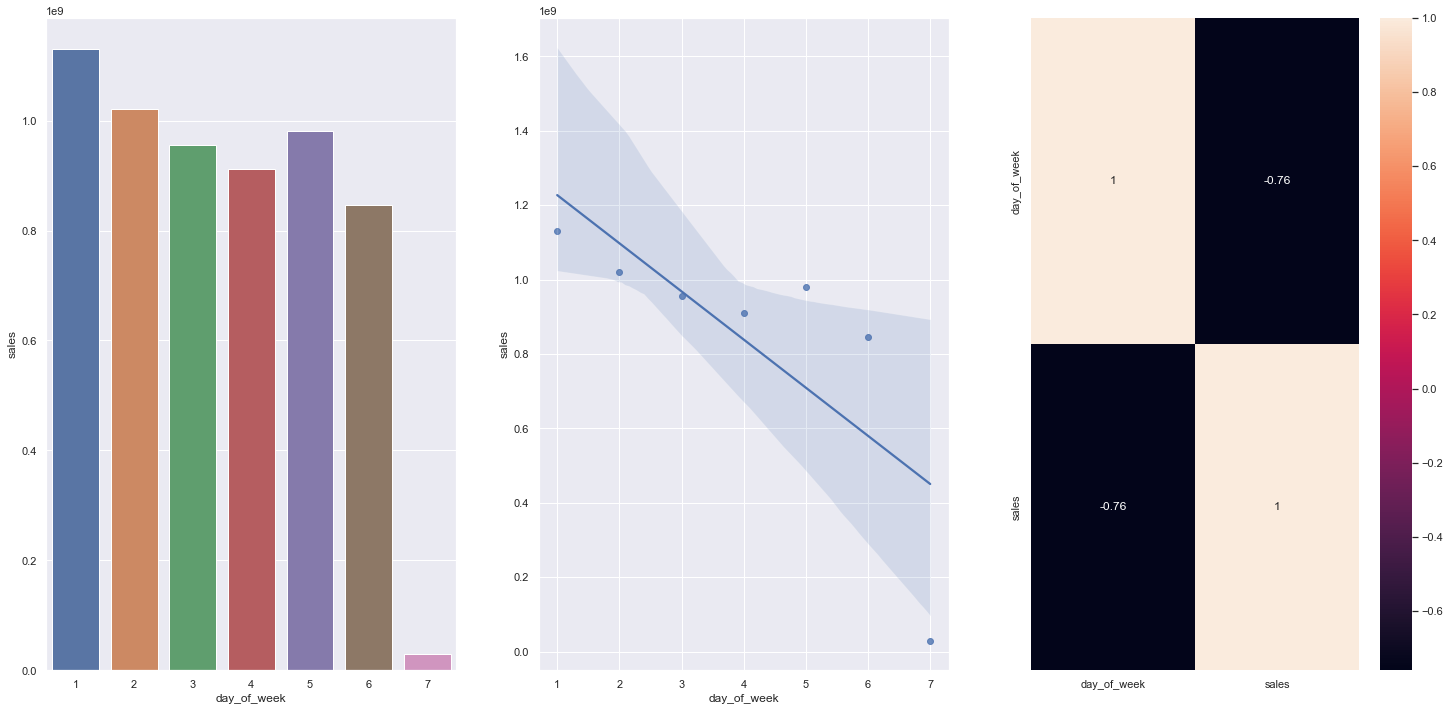

In [407]:
aux1 = df4 [['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot (x ='day_of_week', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x ='day_of_week', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

## H12. - Stores should sell less on hollidays school.

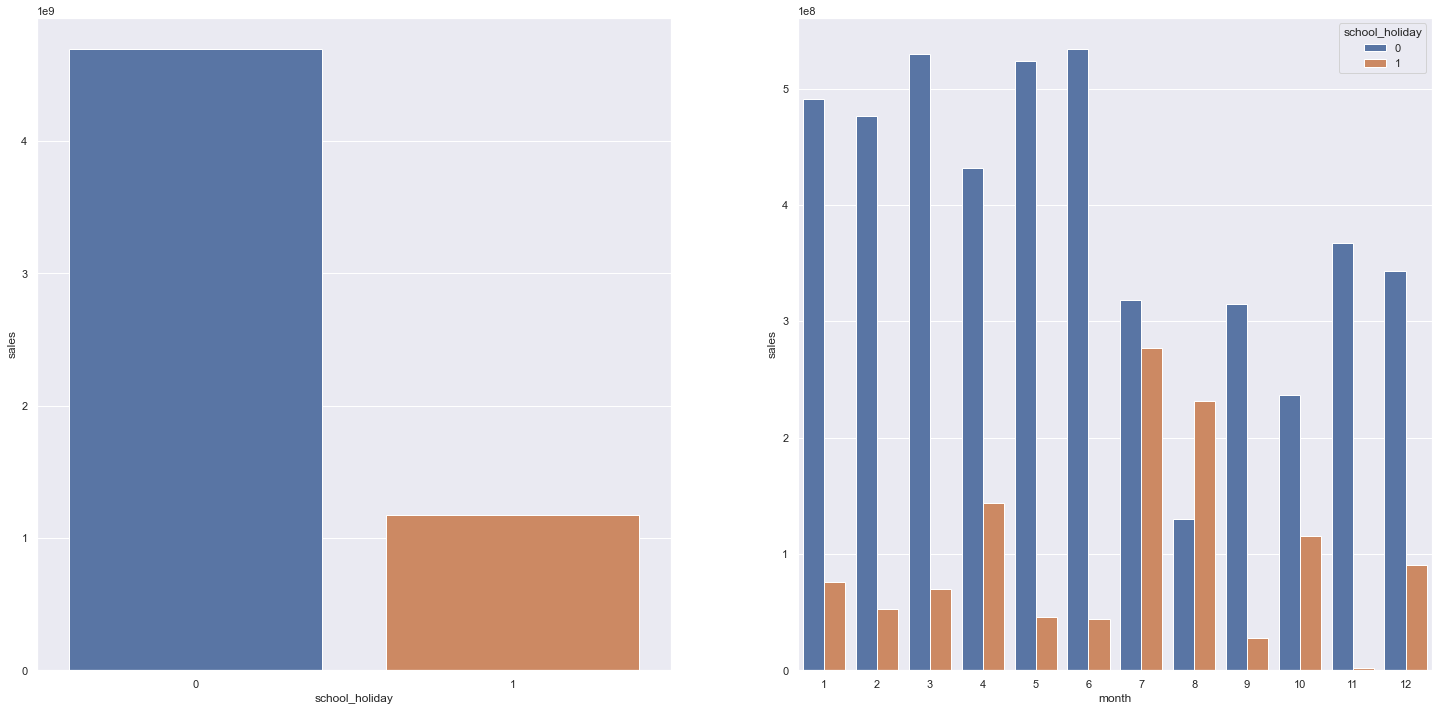

In [408]:
aux1 = df4 [['school_holiday', 'sales']].groupby ('school_holiday').sum().reset_index()

plt.subplot (1, 2, 1)
sns.barplot (x = 'school_holiday', y ='sales', data = aux1);

aux2 = df4 [['month', 'school_holiday', 'sales']].groupby (['month', 'school_holiday']).sum().reset_index()

plt.subplot (1, 2, 2)
sns.barplot (x = 'month', y ='sales', hue = 'school_holiday',  data = aux2);




## 4.2.1 Hipothesys Resume

In [409]:
tab = [[ 'Hipothesys', 'Conclusion', 'Relevance'],
       [ 'H1', 'False', 'Low'],
       [ 'H2', 'False', 'Median'],
       [ 'H3', 'False', 'Median'],
       [ 'H4', 'False', 'Median'],
       [ 'H5', '-', '-'],
       [ 'H6', 'False', 'Low'], 
       [ 'H7', 'False', 'Median'],
       [ 'H8', 'False', 'High'],
       [ 'H9', 'False', 'High'],
       [ 'H10', 'True', 'High'],
       [ 'H11', 'True', 'High'],
       [ 'H12', 'True', 'Low']
      ]

print (tabulate (tab, headers = 'firstrow'))
       



Hipothesys    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Median
H3            False         Median
H4            False         Median
H5            -             -
H6            False         Low
H7            False         Median
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Analise Multvariada

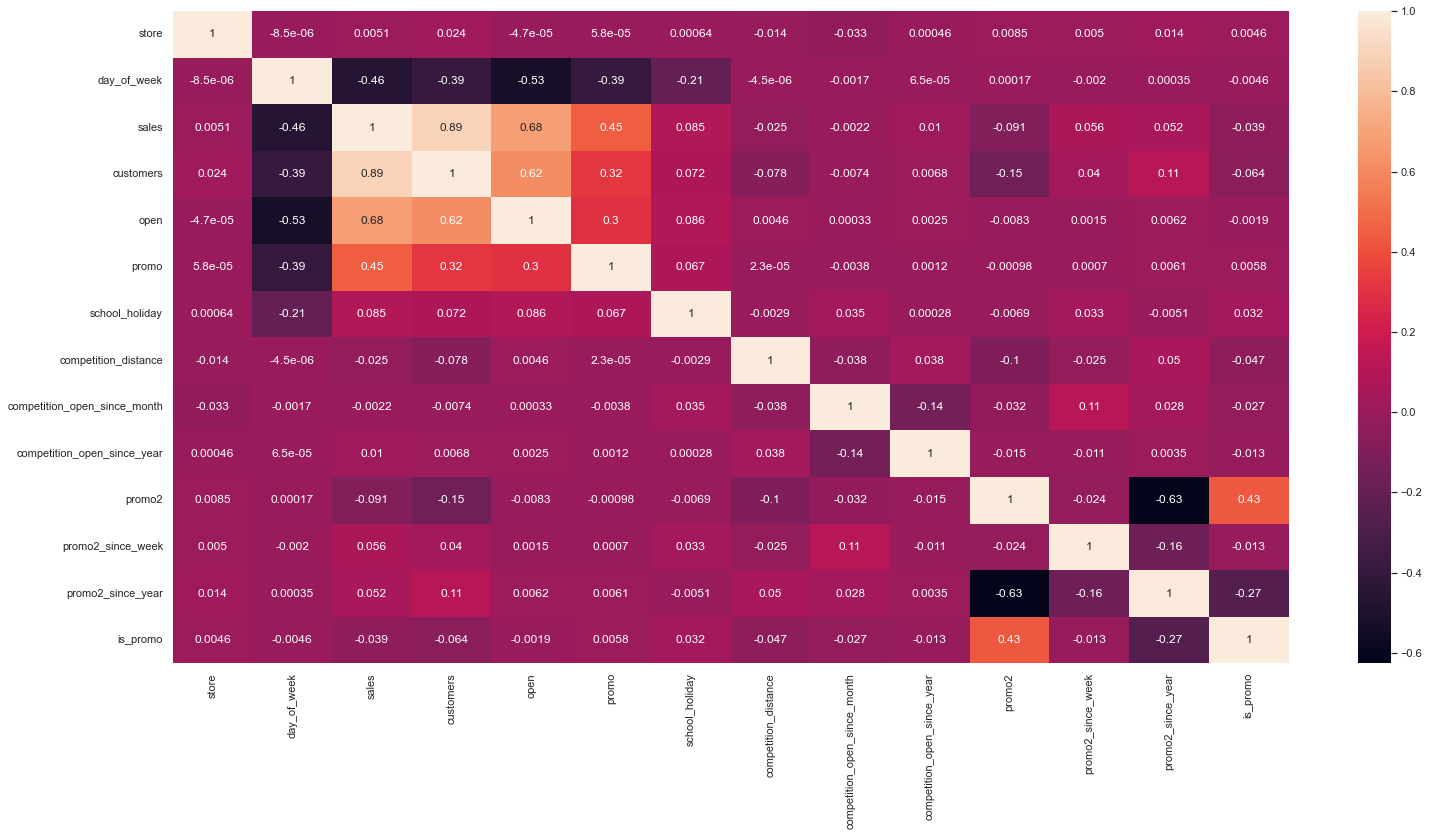

In [410]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

## 4.3.2 Categorical Attributes

<AxesSubplot:>

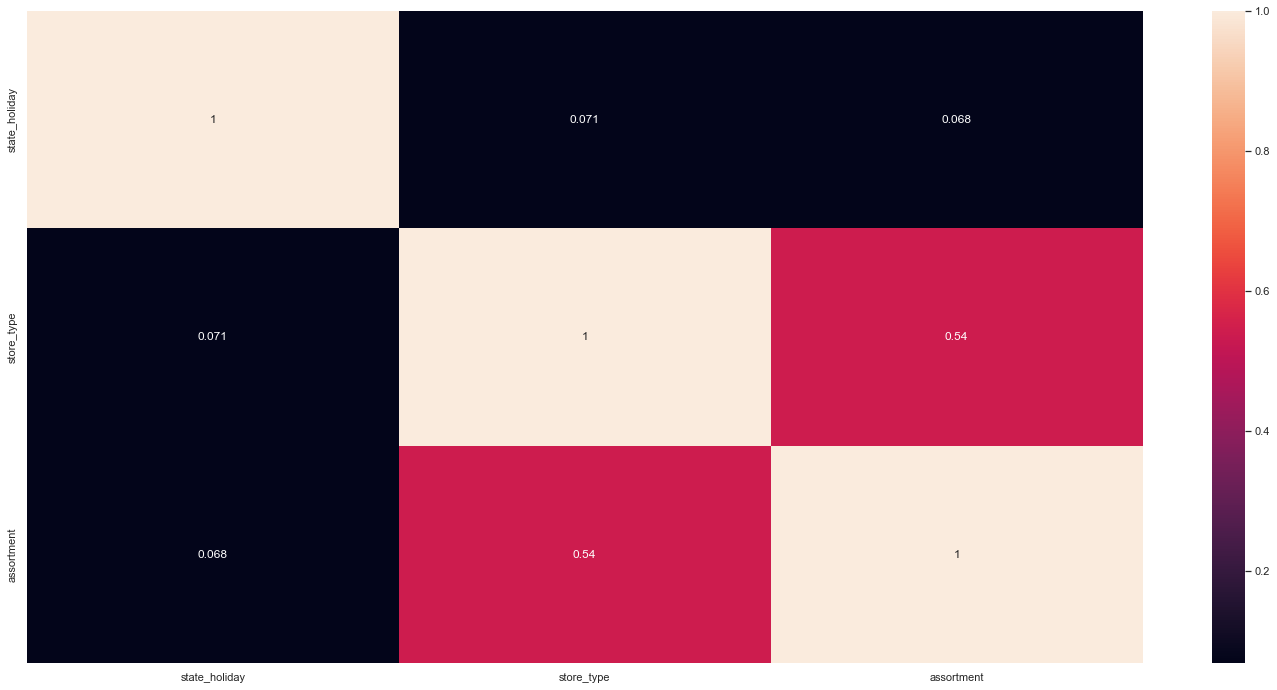

In [411]:
# Only Categorical Data
a = df4.select_dtypes (include = 'object')


# Calculate Data
a1 = cramer_v (a[ 'state_holiday'], a['state_holiday'])
a2 = cramer_v (a[ 'state_holiday'], a['store_type'])
a3 = cramer_v (a[ 'state_holiday'], a['assortment'])

a4 = cramer_v (a[ 'store_type'], a['state_holiday'])
a5 = cramer_v (a[ 'store_type'], a['store_type'])
a6 = cramer_v (a[ 'store_type'], a['assortment'])

a7 = cramer_v (a[ 'assortment'], a['state_holiday'])
a8 = cramer_v (a[ 'assortment'], a['store_type'])
a9 = cramer_v (a[ 'assortment'], a['assortment'])


# Final Dataset
d = pd.DataFrame ({'state_holiday' : [a1, a2, a3],
              'store_type' : [a4, a5, a6],
              'assortment' : [a7, a8, a9]})

d = d.set_index (d.columns)
d

sns.heatmap (d, annot = True)

# 5.0 Data Preparation

In [433]:
df5 = df4.copy ()


/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month '>

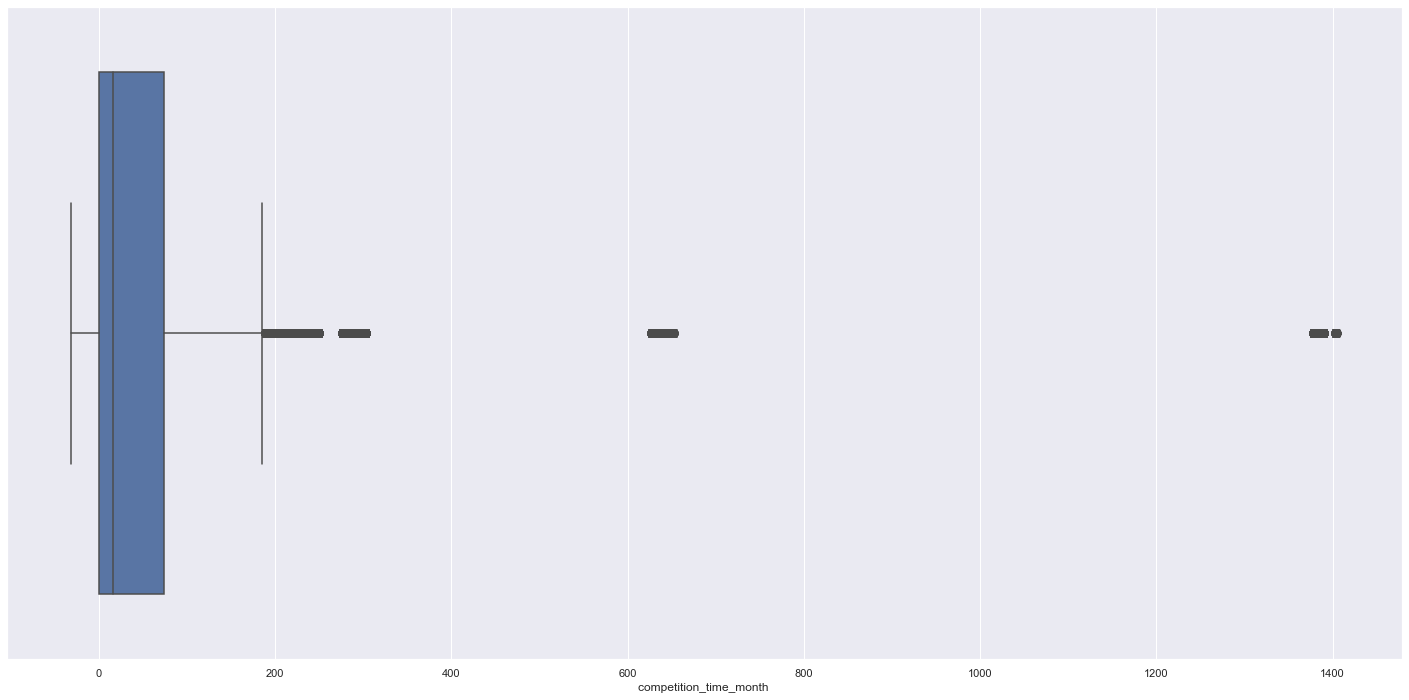

In [434]:
a = df5.select_dtypes (include = ['int64', 'float64'])

sns.boxplot (df5['competition_time_month '])

## 5.1 Normalizacao

In [435]:
# Nao ha nada para normalizar

## 5.2 Rescaling

In [436]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

rs = RobustScaler ()
mms = MinMaxScaler ()

# Competition Distance
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values)

# Competition time month
df5['competition_time_month '] = rs.fit_transform (df5[['competition_time_month ']].values)

# Promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# Year
df5['year'] = mms.fit_transform (df5[['year']].values)

/Users/adriele/opt/anaconda3/envs/env_dsemproducao/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

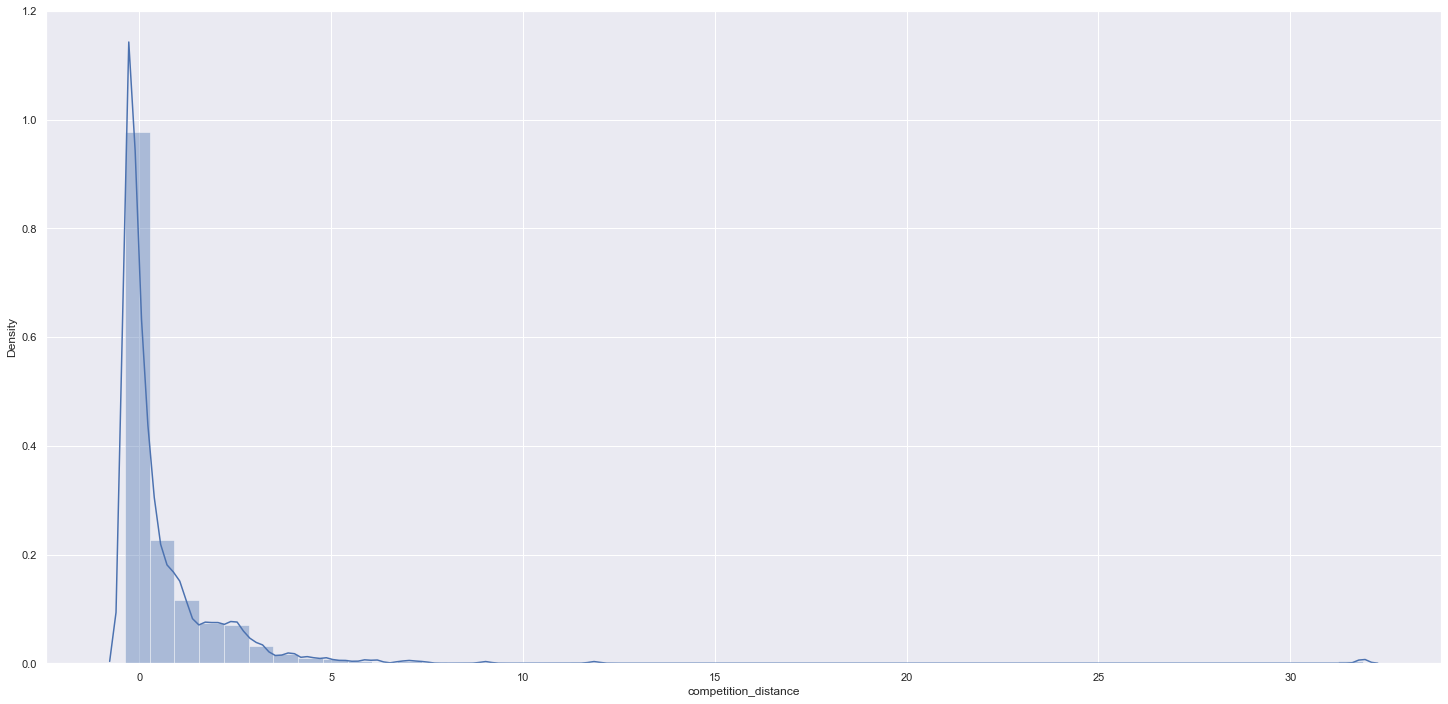

In [437]:
sns.distplot (df5['competition_distance'])

## 5.3 Transformation

### 5.3.1 Encolding

In [438]:
# State Holiday - One Hot Encolding
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])
# sempre vai dar erro pq ja foi rodado


# Store Type - Label Encolding
le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])

# Assortment - Ordinal Encolding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5 ['assortment'] = df5['assortment'].map (assortment_dict)



### 5.3.2 Response Variable Transformation

In [439]:
df5['sales'] = np.log1p (df5 ['sales'])

### 5.3.3 Nature Transformation

In [440]:
# Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x:  np.sin(x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x:  np.cos(x * ( 2. * np.pi/7) ) )

#month
df5['month_sin'] = df5['month'].apply (lambda x:  np.sin(x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply (lambda x:  np.cos(x * ( 2. * np.pi/12) ) )

#day
df5['day_sin'] = df5['day'].apply (lambda x:  np.sin(x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply (lambda x:  np.cos(x * ( 2. * np.pi/30) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x:  np.sin(x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x:  np.cos(x * ( 2. * np.pi/52) ) )

In [441]:
df5.head ()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,2.079117e-01,0.978148,-0.568065,-0.822984
1,1,4,2015-07-30,8.521384,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,30,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.433884,-0.900969,-0.5,-0.866025,-2.449294e-16,1.000000,-0.568065,-0.822984
2,1,3,2015-07-29,8.472823,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,29,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,-2.079117e-01,0.978148,-0.568065,-0.822984
3,1,2,2015-07-28,8.519590,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,28,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.974928,-0.222521,-0.5,-0.866025,-4.067366e-01,0.913545,-0.568065,-0.822984
4,1,1,2015-07-27,8.716536,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,27,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.781831,0.623490,-0.5,-0.866025,-5.877853e-01,0.809017,-0.568065,-0.822984


# 6.0 Feature select

In [447]:
df6 = df5.copy ()

## 6.1 Split data frame into training and test dataset

In [448]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6= df6.drop (cols_drop, axis=1 )

In [449]:
# Training dataset
x_train = df6 [df6 ['date'] < '2015-06-19']
y_train = x_train ['sales']

# Test dataset
x_test = df6 [df6 ['date'] >= '2015-06-19']
y_test = x_test ['sales']

print ( 'Training Min Date: {}'.format (x_train ['date'].min () ) )
print ( 'Training Max Date: {}'.format (x_train ['date'].max () ) )

print ( '\nTest Min Date: {}'.format (x_train ['date'].min () ) )
print ( 'nTest Max Date: {}'.format (x_train ['date'].max () ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2013-01-01 00:00:00
nTest Max Date: 2015-06-18 00:00:00


## 6.2  Boruta as Feature Selector

In [460]:
# training and test dataset for boruta
x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel ()

# Defining Random Forest Regressor
rf = RandomForestRegressor ( n_jobs=-1 )

# Defining boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit (x_train_n, y_train_n)




Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [461]:
x_train_n

array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.09016994e-01,  1.20536680e-01, -9.92708874e-01],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -9.13545458e-01,  1.20536680e-01, -9.92708874e-01],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -9.78147601e-01,  1.20536680e-01, -9.92708874e-01],
       ...,
       [ 1.11500000e+03,  0.00000000e+00,  1.00000000e+00, ...,
         6.69130606e-01,  1.20536680e-01,  9.92708874e-01],
       [ 1.11500000e+03,  0.00000000e+00,  1.00000000e+00, ...,
         8.09016994e-01,  1.20536680e-01,  9.92708874e-01],
       [ 1.11500000e+03,  0.00000000e+00,  1.00000000e+00, ...,
         9.13545458e-01,  1.20536680e-01,  9.92708874e-01]])

### 6.2.1 Best Feature from Boruta

In [462]:

cols_selected = boruta.support_.tolist()

# Best features
x_train_fs = x_train.drop (['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc [:, cols_selected].columns.to_list()

# Not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )



## 6.3 Manual Feature Select


In [503]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'competition_time_month ',
    'promo2',
    'promo2_since_week', 
    'promo2_since_year',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


# columns to add
feat_to_add = ['date', 'sales']

# final Features


cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0 Machine Learning Modelling

In [561]:
X_train = x_train [ cols_selected_boruta_full]
X_test = x_test [cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Avarange Model

In [465]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename ( columns= {'sales': 'predictions'})
aux1 = pd.merge ( aux1, aux2, how='left', on='store')
yhat_baseline = aux1 ['predictions']


# Performace
baseline_result = ml_error( 'Avarage Model', np.expm1 ( y_test ), np.expm1 ( yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.413001,1835.135542


## 7.2 Linear Regression Model

In [466]:
# Model
lr = LinearRegression().fit( X_train, y_train)

# Prediction
yhat_lr = lr.predict ( X_test)

# Performace
lr_result = ml_error ( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.258022,0.292732,2671.35686


### 7.2.1 Linear Regression Model - Cross validation

In [575]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [576]:
# Model
lrr = Lasso( alpha=0.01).fit( X_train, y_train)

# Prediction
yhat_lrr = lrr.predict ( X_test)

# Performace
lrr_result = ml_error ( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

### 7.3.1 Linear Regression Regularized Model - Lasso - Cross validation

In [577]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [468]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train)

# Prediction
yhat_rf = rf.predict ( X_test)

# Performace
rf_result = ml_error ( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,668.263915,0.09775,1004.759734


### 7.4.1 Random Forest Regressor  - Cross validation

In [578]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFOLD Number: 5

KFOLD Number: 4

KFOLD Number: 3

KFOLD Number: 2

KFOLD Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,837.65 +/- 217.44,0.12 +/- 0.02,1256.5 +/- 318.06


## 7.5 XGBoost Regressor

In [469]:
# Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytee = 0.9).fit( X_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict ( X_test)

# Performace
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[06:00:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.713202,0.949509,7330.943947


### 7.5.1 XGBoost Regressor - Cross Validation

In [584]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

[10:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:06:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:07:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,7047.85 +/- 587.56,0.95 +/- 0.0,7713.93 +/- 688.66


## 7.6 Compare Model's Performace

### 7.6.1 Single Performace - Cross Validation

In [582]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,668.263915,0.097750,1004.759734
0,Avarage Model,1354.800353,0.413001,1835.135542
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,Linear Regression,1980.039151,0.283893,2840.000319
0,XGBoost Regressor,6683.713202,0.949509,7330.943947


### 7.6.2 Real Performace - Cross Validation

In [585]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.65 +/- 217.44,0.12 +/- 0.02,1256.5 +/- 318.06
0,XGBoost Regressor,7047.85 +/- 587.56,0.95 +/- 0.0,7713.93 +/- 688.66


#  a